# Modelo de Tópicos - Latent Dirichlet Allocation

## Motivación

Los __modelos de tópicos__ permiten descubrir, a partir de los propios textos, el conjunto de tópicos o temas que estos abordan. Se trata de un análisis automatizado, que sería muy difícil de llevar a cabo manualmente por personas, debido a la cantidad y tamaño de los textos.

- Revisar el artículo "Probabilistic Topic Models" : https://drive.google.com/open?id=1rSQPJvRVj0V_IChzspQMRPNwlDTkHYHp

Uno de los algoritmos más comunes para aprender modelos de tópicos es el algoritmo _Latent Dirichlet Allocation (LDA)_. LDA modela os textos como provenientes de un modelo generativo, con una estructura oculta de tópicos y distribución de palabras en cada tópico, cuyas distribuciones a priori son Dirichlet.

- Revisar el artículo "Latent Dirichlet Allocation" : https://drive.google.com/file/d/1BobImO3192hifZPLXowd14gryVAUzBPW/view



## ¿Qué hace Latent Dirichlet Allocation?

Dado un número de tópicos definido por el analista, el modelo permite asociar una distribución de tópicos $\theta_d$ a cada texto $d$ y al mismo tiempo, la distribución de palabras $\beta_t$ en cada tópico $t$.

<img src="img/f1.jpg"/>

<img src="img/f2.jpg"/>

## Tutorial práctico

En este tutorial, tomaremos un dataset de posts en un foro en inglés y utilizaremos a LDA para descubrir cuáles son los tópicos conversados.

Utilizaremos la implementación de LDA de la libreria Gensim.

### 1.  Instalación de librerias y depedencias

Utilizaremos en particular:
- la libreria NLTK (Natural Language ToolKit) para tener una lista de "stopwords" del inglés
- el modelo inglés de Spacy para preprocesar los textos y lematizar las palabras
- la librería pyLDAvis que ofrece algunas herramientas de visualización de modelos de tópicos

In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ignacio/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
#import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/ignacio/miniconda3/envs/exp/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### 2. Dataset y preprocessing

El dataset que utilizamos contiene aproximadamente 11.000 posts en el foro newsgroup donde las personas pueden hablar de distintos temas. 

In [43]:
# Import Dataset
df1 = pd.read_csv('chile_2021-02.csv')
df1.dropna(subset=['text'], inplace=True)
df2 = pd.read_csv('chile_2021-03.csv')
df2.dropna(subset=['text'], inplace=True)
df = df1.append(df2, ignore_index=True)
#print(df.target_names.unique())
df.head()

,id,country,media_outlet,url,title,text,date,year,id_journalist
0,12095877,chile,emol,https://www.emol.com/noticias/Economia/2021/02/28/1013384/Mejoras-niveles-de-negocio-Latinoamerica.html,El clima de negocios en Latinoamérica sigue desfavorable por temor al covid-19: Chile logra mejora,"Según los últimos resultados del Indicador de Clima Económico (ICE) de Latinoamérica , el ambiente para los negocios en el sector mostró una leve mejoría. No obstante, se mantuvo en niveles desfavorables durante el cuarto trimestre del año 2020, por temor a una segunda ola d contagios por covid-19. RelacionadasDetalle('1013363','1011801'); Así lo informó el centro brasileño de estudios económicos Fundación Getulio Vargas (FGV) , encargado de efectuar esta medición cada tres meses. Cabe destacar que el ICE se obtiene a partir de dos indicadores, el de la Situación Actual (SA) y el de Expectativas (IE) , que evalúa la proyección de los economistas de diversos países para los próximos seis meses. Vale mencionar que, cuando los tres referentes se sitúan por encima de los cien puntos, se considera que el clima es ""favorable"" Es así que el estudio reveló que, en el periodo actual, el ISA escaló trece puntos en comparación con el trimestre anterior, y se situó en 19,4 puntos. Por su...",2021-02-28,NaN,NaN
1,12095927,chile,emol,https://www.emol.com/noticias/Economia/2021/02/27/1013408/David-Bravo-analiza-mercado-laboral.html,"Economista David Bravo advierte: ""Cuando retomemos cierto grado de normalidad, no sabemos si los empleos van a estar""","La pérdida de impulso en la recuperación de empleos y la efectividad de los apoyos que ha entregado el Gobierno en materia laboral son algunos de los puntos que analizó el director del Centro de Encuestas y Estudios Longitudinales de la U. Católica, David Bravo. RelacionadasDetalle('1013349','1013327'); En esa línea, los últimos resultados revelados por el Instituto Nacional de Estadísticas (INE) exhibieron una desaceleración del mercado laboral, puesto que la tasa de desempleo correspondiente al trimestre móvil noviembre 2020 – enero 2021 se situó en un 10,2%, mostrando una mínima baja de 0,1 puntos porcentuales (pp), en comparación al periodo interior (10,3%). Durante el periodo, además, se crearon sólo 95 mil puestos de trabajo. Uno de los motivos que, según Bravo, influyó en las cifras tiene directa relación con el aumento de los contagios por covid- 19 registrados durante el mes de diciembre, lo que derivó en retrocesos para las distintas comunas, en el marco del plan ...",2021-02-27,NaN,NaN
2,12095975,chile,emol,https://www.emol.com/noticias/Economia/2021/02/27/1013429/Sofofa-Carabineros-Araucania-legitimidad.html,"Sofofa llama a ""respaldar"" y ""dar legitimidad"" a Carabineros, PDI y FF.AA. por violencia en La Araucanía","A través de una carta dirigida a las principales autoridades políticas del país, la Sofofa expresa su parecer ante los hechos de violencia que ocurren en La Araucanía. En la misiva plantean cuatro desafíos , siendo el primero de ellos el llamado a que ""se requiere de un compromiso explícito de los sectores políticos, del oficialismo y la oposición, que están por la vía republicana, para apoyar, validar y legitimar el rol que ejercen las fuerzas de orden y seguridad en toda democracia. .. Más precisamente, nos referimos al necesario respaldo a las funciones que recaen en Carabineros, Policía de Investigaciones y las Fuerzas Armadas, en general, cuando les corresponda a estas últimas ejercer algún rol durante estados de excepción constitucional. Es imperativo dotar de más legitimidad al ejercicio de sus funciones hoy, no mañana"". Revisa todos los detalles de la carta en la edición de hoy de El Mercurio.",2021-02-27,NaN,NaN
3,12096020,chile,emol,https://www.emol.com/noticias/Economia/2021/02/26/1013400/cenconsud-nueva-presidenta-licencia-Paulmann.html,Cencosud nombra como presidenta interina a Heike Paulmann ante licencia médica de su padre,"El holding chileno Cencosud informó que s

In [4]:
df

,id,country,media_outlet,url,title,text,date,year,id_journalist
0,12095877,chile,emol,https://www.emol.com/noticias/Economia/2021/02...,El clima de negocios en Latinoamérica sigue de...,Según los últimos resultados del Indicador de...,2021-02-28,NaN,NaN
1,12095927,chile,emol,https://www.emol.com/noticias/Economia/2021/02...,"Economista David Bravo advierte: ""Cuando retom...",La pérdida de impulso en la recuperación de em...,2021-02-27,NaN,NaN
2,12095975,chile,emol,https://www.emol.com/noticias/Economia/2021/02...,"Sofofa llama a ""respaldar"" y ""dar legitimidad""...",A través de una carta dirigida a las principal...,2021-02-27,NaN,NaN
3,12096020,chile,emol,https://www.emol.com/noticias/Economia/2021/02...,Cencosud nombra como presidenta interina a Hei...,El holding chileno Cencosud informó que su d...,2021-02-26,NaN,NaN
4,12096074,chile,emol,https://www.emol.com/noticias/Economia/2021/02...,"Palacios dice que inicio económico de 2021 ""no...",""" El inicio de año no será fácil pues tiene un...",2021-02-26,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4715,17781918,chile,emol,https://www.emol.com/noticias/Autos/2021/03/31...,Startup Lilium presenta nuevo y moderno vehícu...,Con la era de los eVTOL (vehículos eléctricos ...,2021-03-31,NaN,NaN
4716,17781934,chile,emol,https://www.emol.com/noticias/Autos/2021/03/31...,Tres icónicos autos del piloto Ken Block salen...,El famoso piloto Ken Block decidió llevar a ...,2021-03-31,NaN,NaN
4717,17781979,chile,emol,https://www.emol.com/noticias/Autos/2021/03/31...,Los todoterrenos de Toyota celebran siete déca...,El fabricante de autos japonés Toyota celebra ...,2021-03-31,NaN,NaN
4718,17781982,chile,emol,https://www.emol.com/noticias/Autos/2021/03/31...,Adrenalina tuerca y emoción de la velocidad: R...,La temporada 2021 del Copec RallyMobil inició ...,2021-03-31,NaN,NaN


In [5]:
#df.dropna(subset=['text'], inplace=True)

In [44]:
df['text'] = df.text.astype(str)
df['url'] = df.url.astype(str)

In [45]:
df

,id,country,media_outlet,url,title,text,date,year,id_journalist
0,12095877,chile,emol,https://www.emol.com/noticias/Economia/2021/02/28/1013384/Mejoras-niveles-de-negocio-Latinoamerica.html,El clima de negocios en Latinoamérica sigue desfavorable por temor al covid-19: Chile logra mejora,"Según los últimos resultados del Indicador de Clima Económico (ICE) de Latinoamérica , el ambiente para los negocios en el sector mostró una leve mejoría. No obstante, se mantuvo en niveles desfavorables durante el cuarto trimestre del año 2020, por temor a una segunda ola d contagios por covid-19. RelacionadasDetalle('1013363','1011801'); Así lo informó el centro brasileño de estudios económicos Fundación Getulio Vargas (FGV) , encargado de efectuar esta medición cada tres meses. Cabe destacar que el ICE se obtiene a partir de dos indicadores, el de la Situación Actual (SA) y el de Expectativas (IE) , que evalúa la proyección de los economistas de diversos países para los próximos seis meses. Vale mencionar que, cuando los tres referentes se sitúan por encima de los cien puntos, se considera que el clima es ""favorable"" Es así que el estudio reveló que, en el periodo actual, el ISA escaló trece puntos en comparación con el trimestre anterior, y se situó en 19,4 puntos. Por su...",2021-02-28,NaN,NaN
1,12095927,chile,emol,https://www.emol.com/noticias/Economia/2021/02/27/1013408/David-Bravo-analiza-mercado-laboral.html,"Economista David Bravo advierte: ""Cuando retomemos cierto grado de normalidad, no sabemos si los empleos van a estar""","La pérdida de impulso en la recuperación de empleos y la efectividad de los apoyos que ha entregado el Gobierno en materia laboral son algunos de los puntos que analizó el director del Centro de Encuestas y Estudios Longitudinales de la U. Católica, David Bravo. RelacionadasDetalle('1013349','1013327'); En esa línea, los últimos resultados revelados por el Instituto Nacional de Estadísticas (INE) exhibieron una desaceleración del mercado laboral, puesto que la tasa de desempleo correspondiente al trimestre móvil noviembre 2020 – enero 2021 se situó en un 10,2%, mostrando una mínima baja de 0,1 puntos porcentuales (pp), en comparación al periodo interior (10,3%). Durante el periodo, además, se crearon sólo 95 mil puestos de trabajo. Uno de los motivos que, según Bravo, influyó en las cifras tiene directa relación con el aumento de los contagios por covid- 19 registrados durante el mes de diciembre, lo que derivó en retrocesos para las distintas comunas, en el marco del plan ...",2021-02-27,NaN,NaN
2,12095975,chile,emol,https://www.emol.com/noticias/Economia/2021/02/27/1013429/Sofofa-Carabineros-Araucania-legitimidad.html,"Sofofa llama a ""respaldar"" y ""dar legitimidad"" a Carabineros, PDI y FF.AA. por violencia en La Araucanía","A través de una carta dirigida a las principales autoridades políticas del país, la Sofofa expresa su parecer ante los hechos de violencia que ocurren en La Araucanía. En la misiva plantean cuatro desafíos , siendo el primero de ellos el llamado a que ""se requiere de un compromiso explícito de los sectores políticos, del oficialismo y la oposición, que están por la vía republicana, para apoyar, validar y legitimar el rol que ejercen las fuerzas de orden y seguridad en toda democracia. .. Más precisamente, nos referimos al necesario respaldo a las funciones que recaen en Carabineros, Policía de Investigaciones y las Fuerzas Armadas, en general, cuando les corresponda a estas últimas ejercer algún rol durante estados de excepción constitucional. Es imperativo dotar de más legitimidad al ejercicio de sus funciones hoy, no mañana"". Revisa todos los detalles de la carta en la edición de hoy de El Mercurio.",2021-02-27,NaN,NaN
3,12096020,chile,emol,https://www.emol.com/noticias/Economia/2021/02/26/1013400/cenconsud-nueva-presidenta-licencia-Paulmann.html,Cencosud nombra como presidenta interina a Heike Paulmann ante licencia médica de su padre,"El holding chileno Cencosud informó que s

In [54]:
categorias=[]
for s in list(df['url']):
    c=s.split('/')[4]
    if not (c in categorias):
        categorias.append(c)
categorias

['Economia',
 'Nacional',
 'Internacional',
 'Tecnologia',
 'Tendencias',
 'Deportes',
 'Autos']

In [51]:
df['url'][0].split('/')[3]

'noticias'

In [8]:
df['text'][0]

'Según los últimos resultados del  Indicador de Clima Económico (ICE) de Latinoamérica , el ambiente para los negocios en el sector mostró una leve mejoría. No obstante, se mantuvo en niveles desfavorables durante el cuarto trimestre del año 2020, por temor a una segunda ola d contagios por covid-19.  RelacionadasDetalle(\'1013363\',\'1011801\'); Así lo informó el centro brasileño de estudios económicos  Fundación Getulio Vargas (FGV) , encargado de efectuar esta medición cada tres meses. Cabe destacar que el ICE se obtiene a partir de dos indicadores, el de la  Situación Actual (SA) y el de Expectativas (IE) , que evalúa la proyección de los economistas de diversos países para los próximos seis meses. Vale mencionar que, cuando los tres referentes se sitúan por encima de los cien puntos, se considera que el clima es "favorable" Es así que el estudio reveló que, en el periodo actual,  el ISA escaló trece puntos en comparación con el trimestre anterior, y se situó en 19,4 puntos.  Por s

In [9]:
df.dtypes

id                 int64
country           object
media_outlet      object
url               object
title             object
text              object
date              object
year             float64
id_journalist    float64
dtype: object

In [10]:
df["text"][0]

'Según los últimos resultados del  Indicador de Clima Económico (ICE) de Latinoamérica , el ambiente para los negocios en el sector mostró una leve mejoría. No obstante, se mantuvo en niveles desfavorables durante el cuarto trimestre del año 2020, por temor a una segunda ola d contagios por covid-19.  RelacionadasDetalle(\'1013363\',\'1011801\'); Así lo informó el centro brasileño de estudios económicos  Fundación Getulio Vargas (FGV) , encargado de efectuar esta medición cada tres meses. Cabe destacar que el ICE se obtiene a partir de dos indicadores, el de la  Situación Actual (SA) y el de Expectativas (IE) , que evalúa la proyección de los economistas de diversos países para los próximos seis meses. Vale mencionar que, cuando los tres referentes se sitúan por encima de los cien puntos, se considera que el clima es "favorable" Es así que el estudio reveló que, en el periodo actual,  el ISA escaló trece puntos en comparación con el trimestre anterior, y se situó en 19,4 puntos.  Por s

In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [12]:
#stop_words

- Utilizamos expresiones regulares (libreria "re") para suprimir los emails, espacios blancos y caracteres que podrian generan ruido en el análisis.

In [13]:
# Convert to list
data = df.text.values.tolist()
data[0]

'Según los últimos resultados del  Indicador de Clima Económico (ICE) de Latinoamérica , el ambiente para los negocios en el sector mostró una leve mejoría. No obstante, se mantuvo en niveles desfavorables durante el cuarto trimestre del año 2020, por temor a una segunda ola d contagios por covid-19.  RelacionadasDetalle(\'1013363\',\'1011801\'); Así lo informó el centro brasileño de estudios económicos  Fundación Getulio Vargas (FGV) , encargado de efectuar esta medición cada tres meses. Cabe destacar que el ICE se obtiene a partir de dos indicadores, el de la  Situación Actual (SA) y el de Expectativas (IE) , que evalúa la proyección de los economistas de diversos países para los próximos seis meses. Vale mencionar que, cuando los tres referentes se sitúan por encima de los cien puntos, se considera que el clima es "favorable" Es así que el estudio reveló que, en el periodo actual,  el ISA escaló trece puntos en comparación con el trimestre anterior, y se situó en 19,4 puntos.  Por s

In [14]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

data[0]

'Según los últimos resultados del Indicador de Clima Económico (ICE) de Latinoamérica , el ambiente para los negocios en el sector mostró una leve mejoría. No obstante, se mantuvo en niveles desfavorables durante el cuarto trimestre del año 2020, por temor a una segunda ola d contagios por covid-19. RelacionadasDetalle(1013363,1011801); Así lo informó el centro brasileño de estudios económicos Fundación Getulio Vargas (FGV) , encargado de efectuar esta medición cada tres meses. Cabe destacar que el ICE se obtiene a partir de dos indicadores, el de la Situación Actual (SA) y el de Expectativas (IE) , que evalúa la proyección de los economistas de diversos países para los próximos seis meses. Vale mencionar que, cuando los tres referentes se sitúan por encima de los cien puntos, se considera que el clima es "favorable" Es así que el estudio reveló que, en el periodo actual, el ISA escaló trece puntos en comparación con el trimestre anterior, y se situó en 19,4 puntos. Por su parte, el IE

- Gensim tiene una función "simple_preprocess" que tokeniza los textos, suprima las puntuaciones y transforma un texto en una lista de tokens

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(data))

In [16]:
print(data_words[0])

['segun', 'los', 'ultimos', 'resultados', 'del', 'indicador', 'de', 'clima', 'economico', 'ice', 'de', 'latinoamerica', 'el', 'ambiente', 'para', 'los', 'negocios', 'en', 'el', 'sector', 'mostro', 'una', 'leve', 'mejoria', 'no', 'obstante', 'se', 'mantuvo', 'en', 'niveles', 'desfavorables', 'durante', 'el', 'cuarto', 'trimestre', 'del', 'ano', 'por', 'temor', 'una', 'segunda', 'ola', 'contagios', 'por', 'covid', 'asi', 'lo', 'informo', 'el', 'centro', 'brasileno', 'de', 'estudios', 'economicos', 'fundacion', 'getulio', 'vargas', 'fgv', 'encargado', 'de', 'efectuar', 'esta', 'medicion', 'cada', 'tres', 'meses', 'cabe', 'destacar', 'que', 'el', 'ice', 'se', 'obtiene', 'partir', 'de', 'dos', 'indicadores', 'el', 'de', 'la', 'situacion', 'actual', 'sa', 'el', 'de', 'expectativas', 'ie', 'que', 'evalua', 'la', 'proyeccion', 'de', 'los', 'economistas', 'de', 'diversos', 'paises', 'para', 'los', 'proximos', 'seis', 'meses', 'vale', 'mencionar', 'que', 'cuando', 'los', 'tres', 'referentes', 's

- Para extraer los tópicos de un conjunto de documentos, puede ser muy relevante añadir "conceptos" (palabras de más de 1 token) a nuestro vocabulario. Por lo tanto guardaremos tambien los "bigrams" y "trigrams" más frecuentes.

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[16]]])

['espero', 'que', 'el', 'crecimiento', 'de', 'este', 'compense', 'la', 'caida', 'que', 'tuvimos', 'en', 'preliminarmente', 'por', 'tanto', 'que', 'tengamos', 'una', 'recuperacion_economica', 'fuerte', 'que', 'signifique', 'nuevas', 'mejores', 'oportunidades', 'para', 'las', 'pymes', 'para', 'las', 'familias_chilenas', 'asi', 'ayer', 'el', 'presidente_sebastian_pinera', 'hacia', 'una', 'estimacion', 'respecto', 'del', 'pib', 'para', 'este', 'ano', 'en', 'medio', 'del', 'mayor', 'optimismo', 'que', 'genera', 'el', 'solido', 'proceso', 'de', 'vacunacion', 'que', 'sigue', 'adelante', 'en', 'el', 'pais', 'sin_embargo', 'esta', 'estimacion', 'no', 'es', 'la', 'unica', 'que', 'muestra', 'que', 'este', 'ano', 'la', 'actividad', 'podria', 'recuperar', 'todo', 'lo', 'perdido', 'el', 'ano', 'pasado', 'algunos', 'analisis', 'de', 'entidades', 'financieras', 'que', 'han', 'corregido', 'al', 'alza', 'su', 'estimacion', 'para', 'el', 'pib', 'chileno', 'de', 'no', 'descartan', 'que', 'la', 'economia',

In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

- Se aplican las funciones para suprimir stopwords, añadir bigrams y lematizar las palabras con los modelos de spacy

In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])
#nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [21]:
print(data_lemmatized[1])

['perdido', 'efectividad', 'apoyo', 'entregar', 'laboral', 'punto', 'analizar', 'director', 'encuestar', 'estudio', 'longitudinal', 'catolica', 'linear', 'ultimos', 'resultar', 'revelar', 'exhibir', 'tasar', 'desempleo', 'correspondiente', 'minima', 'bajo', 'comparacion', 'periodo', 'interior', 'periodo', 'ademar', 'crear', 'solo', 'puesto', 'trabajar', 'motivo', 'influir', 'cifrar', 'directo', 'aumentar', 'contagio', 'registrar', 'derivar', 'retroceso', 'comuna', 'marcar', 'plan_paso', 'pasar', 'diciembre', 'estancar', 'directo', 'mes', 'especialmente', 'region_metropolitana', 'anadio', 'comparar', 'mes', 'mayor', 'crisis', 'terminos', 'emplear', 'mes', 'julio', 'justamente', 'ultimar', 'periodo', 'cuarentena', 'mas', 'estricto', 'asi', 'comprobar', 'emplear', 'bastante', 'asociar', 'grado', 'movilidad', 'posible', 'bastante', 'inmediato', 'pasar', 'diciembre', 'futuro', 'preve', 'optimismo', 'iniciar', 'procesar', 'vacunacion', 'restricción', 'perspectivo', 'medir', 'poder', 'haber',

### 3. Preparar los datos de input de LDA

los datos de input principales de LDA son: un diccionario (id2word) y nuestro dataset preprocesado (data_lemmatized).

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word

- Se asigna una ID a cada palabra (o concepto) del vocabulario

In [23]:
id2word[0]

'3'

In [24]:
# Create Corpus
texts = data_lemmatized

- Se crea una representación "Bag of words" del dataset como input de LDA.

Nota Bene: existen implementaciones de LDA que reciben como input representaciones con "Word Embedding". Ver por ejemplo: https://towardsdatascience.com/combing-lda-and-word-embeddings-for-topic-modeling-fe4a1315a5b4 

In [25]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 3), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 2), (58, 2), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 4), (94, 1), (95, 2), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [26]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('3', 1),
  ('acentuar', 1),
  ('actual', 3),
  ('adjudicar', 1),
  ('ambiente', 1),
  ('analisis', 1),
  ('analista', 2),
  ('analizar', 1),
  ('ano', 1),
  ('anterior', 1),
  ('aspecto', 1),
  ('aumentar', 1),
  ('avanzar', 1),
  ('basar', 1),
  ('bastante', 2),
  ('brasileno', 1),
  ('bruto_pib', 1),
  ('cabe_destacar', 1),
  ('caer', 1),
  ('centrar', 1),
  ('cercar', 1),
  ('clima', 3),
  ('condicionar', 1),
  ('considerar', 3),
  ('consultar', 1),
  ('contagiar', 1),
  ('contagio', 1),
  ('continuan', 1),
  ('contrario', 1),
  ('coronavirus', 2),
  ('crecimiento', 1),
  ('cuartar', 1),
  ('cuarto_trimestre', 1),
  ('demorar', 1),
  ('descenso', 1),
  ('desfavorable', 2),
  ('dificultad', 1),
  ('documentar', 1),
  ('economias', 1),
  ('economico', 2),
  ('economicos', 1),
  ('economista', 1),
  ('efectuar', 2),
  ('encargar', 1),
  ('encimar', 1),
  ('especialista', 1),
  ('estable', 1),
  ('estandar', 1),
  ('estudiar', 2),
  ('evaluar', 1),
  ('expectativa', 3),
  ('experto',

### 4. Entrenamiento del modelo de tópico con LDA

- Entrenaremos un primer modelo de tópicos buscando un modelo con 20 tópicos. 

In [27]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### 5. Visualizar los tópicos encontrados

In [28]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics(num_words=25))


[(0,
  '0.051*"carbonar" + 0.026*"deficit" + 0.023*"arenar" + 0.022*"utilidad" + '
  '0.016*"colega" + 0.013*"ambitos" + 0.012*"precipitación" + 0.006*"energias" '
  '+ 0.004*"colateral" + 0.003*"adversidad" + 0.003*"vaco" + 0.000*"chiron" + '
  '0.000*"barco" + 0.000*"arbolar" + 0.000*"segundo" + 0.000*"canal" + '
  '0.000*"trasero" + 0.000*"kilómetro" + 0.000*"retrovisor" + 0.000*"gris" + '
  '0.000*"increible" + 0.000*"paquete" + 0.000*"emisión" + 0.000*"atascar" + '
  '0.000*"remolcador"'),
 (1,
  '0.026*"hacer" + 0.022*"decir" + 0.021*"ser" + 0.016*"tambien" + '
  '0.014*"poder" + 0.013*"ir" + 0.011*"mas" + 0.011*"dar" + 0.011*"partir" + '
  '0.009*"hoy" + 0.008*"presidente" + 0.007*"solo" + 0.007*"ver" + '
  '0.007*"tener" + 0.007*"acordar" + 0.006*"creer" + 0.006*"querer" + '
  '0.006*"bien" + 0.006*"importante" + 0.006*"llegar" + 0.006*"trabajar" + '
  '0.006*"ahora" + 0.006*"momento" + 0.006*"formar" + 0.006*"agregar"'),
 (2,
  '0.137*"rendimiento" + 0.084*"sufrio" + 0.037*"so

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/home/ignacio/miniconda3/envs/exp/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.305311 -0.082089       1        1  37.998004
3      0.303739  0.004487       2        1  17.937149
5      0.285850  0.076867       3        1  15.607395
4      0.180770 -0.294605       4        1   6.586882
19     0.247789  0.143416       5        1   6.130647
11     0.208009  0.203750       6        1   4.422487
12     0.124528  0.130224       7        1   2.537549
8      0.083416 -0.230126       8        1   2.445358
6      0.060636 -0.111141       9        1   2.176187
18    -0.165460  0.006115      10        1   0.697501
15    -0.147248 -0.007097      11        1   0.654909
14    -0.034650  0.110752      12        1   0.601607
16    -0.131372  0.006686      13        1   0.483966
7     -0.168230  0.001042      14        1   0.444213
9     -0.177876 -0.002564      15        1   0.370032
10    -0.175262  0.003348      16        1   0.255730
13    -0.194282  0.008729      17        1   0.232068
17    -0.193235  0.009110      18        1   0.205467
2     -0.201710  0.010548      19        1   0.147443
0     -0.210723  0.012549      20        1   0.065407, topic_info=           Term         Freq        Total Category  logprob  loglift
443    personar  5268.000000  5268.000000  Default  30.0000  30.0000
409       decir  5212.000000  5212.000000  Default  29.0000  29.0000
8           ano  5592.000000  5592.000000  Default  28.0000  28.0000
2932    jugador  1657.000000  1657.000000  Default  27.0000  27.0000
631      millón  2820.000000  2820.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
3487      canal     0.015294     1.042987  Topic20 -10.1989   3.1099
6504    trasero     0.015294     1.042978  Topic20 -10.1989   3.1099
3529    paquete     0.015293     1.042961  Topic20 -10.1989   3.1099
3874    francés     0.015293     1.042951  Topic20 -10.1990   3.1099
5814  excelente     0.015293     1.042936  Topic20 -10.1990   3.1099

[934 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         2  0.996240       3
1351      5  0.987492       6
3174     15  0.922271  abocar
2688      4  0.994935  abogar
999       1  0.296350   abril
...     ...       ...     ...
477       1  0.077151      ﻿1
477       2  0.864830      ﻿1
477       4  0.008817      ﻿1
477       9  0.038208      ﻿1
477      12  0.011022      ﻿1

[1264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 5, 20, 12, 13, 9, 7, 19, 16, 15, 17, 8, 10, 11, 14, 18, 3, 1])

### 6. Calcular las metricas de Perplejidad (_Model Perplexity_) y Coherencia (_Coherence Score_)

La perplejidad del modelo y la coherencia del tema proporcionan metricas estadisticas para evaluar que tan revante es un modelo para describir el dataset.

In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.928855195559418

Coherence Score:  0.46323702749848


### 7. ¿Cómo encontrar cuál es el mejor número de tópicos para describir el dataset?

Buscar el modelo que optimiza la métrica de coherencia (o minimiza la métrica de perplejidad).

In [31]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [32]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=30, step=5)

2
7
12
17
22
27


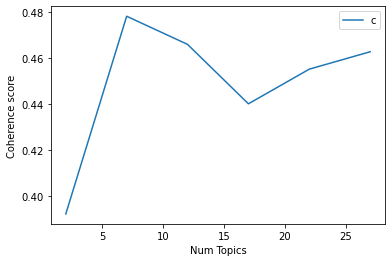

In [33]:
# Show graph
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
# Print the coherence scores
c=0
bc=c
bv=coherence_values[0]
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    if cv>bv:
        bv=cv
        bc=c
    c+=1
print(bc)

Num Topics = 2  has Coherence Value of 0.3921
Num Topics = 7  has Coherence Value of 0.4784
Num Topics = 12  has Coherence Value of 0.4661
Num Topics = 17  has Coherence Value of 0.4401
Num Topics = 22  has Coherence Value of 0.4553
Num Topics = 27  has Coherence Value of 0.4628
1


In [35]:
# Select the model and print the topics

#optimal_model = model_list[4] #elegir manualmente
optimal_model = model_list[bc]



#model_topics = optimal_model.show_topics(formatted=False)
#pprint(optimal_model.print_topics(num_words=10))

In [36]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/home/ignacio/miniconda3/envs/exp/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.145054  0.079781       1        1  45.788283
3     -0.149840 -0.047428       2        1  15.637399
4     -0.133152  0.260063       3        1  13.042398
5     -0.038817 -0.075995       4        1  12.232752
6     -0.107488 -0.250539       5        1   8.445944
2      0.320544  0.008305       6        1   4.226760
0      0.253807  0.025814       7        1   0.626464, topic_info=              Term         Freq        Total Category  logprob  loglift
443       personar  3893.000000  3893.000000  Default  30.0000  30.0000
631         millón  2167.000000  2167.000000  Default  29.0000  29.0000
105     presidente  2521.000000  2521.000000  Default  28.0000  28.0000
483           caso  1505.000000  1505.000000  Default  27.0000  27.0000
2932       jugador  1227.000000  1227.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
8112      caminata     8.555102     9.439234   Topic7  -6.1315   4.9745
18393  empatizamos     8.450993     9.340658   Topic7  -6.1438   4.9727
7046    vespertino     9.435744    10.551454   Topic7  -6.0336   4.9611
1565         clase    54.494915    95.802965   Topic7  -4.2800   4.5086
2729    presencial    48.339146   111.753667   Topic7  -4.3998   4.2348

[413 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
999       1  0.998550    abril
589       1  0.700900  acordar
589       2  0.073064  acordar
589       3  0.034916  acordar
589       4  0.050434  acordar
...     ...       ...      ...
477       1  0.179543       ﻿1
477       2  0.315440       ﻿1
477       3  0.407691       ﻿1
477       4  0.026783       ﻿1
477       5  0.070428       ﻿1

[657 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 6, 7, 3, 1])

### 8. ¿Cuál es el tópico principal de cada documento?

In [37]:
pd.options.display.max_colwidth = 1000

In [38]:
def format_topics_documents(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.7108,"millón, ano, mas, nuevo, mayor, aumentar, vacuno, paises, empresa, mercar","[ultimos, resultar, indicador, clima, economico, negocio, sector, mantener, nivelar, desfavorable, cuarto_trimestre, ano, contagio, informar, centrar, brasileno, economicos, encargar, efectuar, mesar, cabe_destacar, obtener, partir, indicador, actual, expectativa, economista, paises, proximos, mesar, vale_mencionar, referente, situan, encimar, punto, considerar, clima, favorable, estudiar, revelar, periodo, actual, punto, trimestre, anterior, punto, partir, ie, permanecio, estable, punto, segun, estudiar, primero, vez, pandemia, coronavirus, impactar, llenar, mundial, mejorar, paises, expectativa, bastante, heterogeneas, resultar, general, mostrar, especialista, continuan, evaluar, situacion, actual, bastante, desfavorable, optimista, perspectivo, mejoria, proximos_meses, iniciar, programar, mundo, resaltar, documentar, clima, economico, latinoamerica, mitad, paises, analizar, nivel, favorable, aumentar, punto, punto, ubicandose, cercar, estandar, mexico, nacion, ...]"
1,1,1.0,0.4646,"hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar","[perdido, efectividad, apoyo, entregar, laboral, punto, analizar, director, encuestar, estudio, longitudinal, catolica, linear, ultimos, resultar, revelar, exhibir, tasar, desempleo, correspondiente, minima, bajo, comparacion, periodo, interior, periodo, ademar, crear, solo, puesto, trabajar, motivo, influir, cifrar, directo, aumentar, contagio, registrar, derivar, retroceso, comuna, marcar, plan_paso, pasar, diciembre, estancar, directo, mes, especialmente, region_metropolitana, anadio, comparar, mes, mayor, crisis, terminos, emplear, mes, julio, justamente, ultimar, periodo, cuarentena, mas, estricto, asi, comprobar, emplear, bastante, asociar, grado, movilidad, posible, bastante, inmediato, pasar, diciembre, futuro, preve, optimismo, iniciar, procesar, vacunacion, restricción, perspectivo, medir, poder, haber, retomar, nivelar, funcionamiento, segundo_semestre, sector, economia, vestir, fuertemente, afectar, pandemia, existir, incertidumbre, ...]"
2,2,1.0,0.5757,"hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar","[dirigir, principal, autoridad, politicas, expreso, parecer, hecho, violencia, desafios, 1, llamar, requerir, compromiso, explicitar, sector, politicos, apoyar, validar, legitimar, fuerza, seguridad, democracia, mas, precisamente, referir, necesario, respaldar, funcionar, carabinero, policia, investigación, fuerzas_armadas, general, corresponder, ultimar, ejercer, rol, excepcion_constitucional, imperativo, dotar, ejercicio, funcionar, hoy, manana, revisar, detalle, hoy, mercurio]"
3,3,1.0,0.3779,"hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar","[holding, chileno, informar, nombrar, ausencia, licencia_medica, firmar, firmar, mantendra, poner, empresario, controlador, grupo, funcionar, segun, firmar, breve, hacer, esencial, remitir, mercado_financiero, directorio, nombrar, hijo, empresario, formar, unanime, semana, trascendio, empresario, ano, ser, internar, centro_asistencial, realizarse, examenes_medicos, solicitar, licencia_medica, extenderia, presidente, ultimos, dias, encontrar, realizar, examenes_medicos, virtud, solicitar, licencia_medica, mantendra, alejar, periodicas, actividad, febrero, cursar, comunicar, empresa, linear, explicar, periodo, mantener, contactar, principal, ejecutivo, compania]"
4,4,3.0,0.6639,"millón, ano, mas, nuevo, mayor, aumentar, vacuno, paises, empresa, mercar","[iniciar, ano, facil, basar, comparacion, exigente, registro, mejorar, avanzar, seguro, economia_lucas, estimación, mercar, imacec, enero, proximo, lunes, analisis, actividad_economica, ﻿1, mes, ano, ira, mejorar, medir, decir, viernes, cifrar, sectorial, publicar, enero, registrar, retroceso, mas, profundar, diciembre, entidad, destacar, produccion_industrial, tercero, vez,

In [65]:
df_dominant_topic.head(4716)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.7108,"millón, ano, mas, nuevo, mayor, aumentar, vacuno, paises, empresa, mercar","[ultimos, resultar, indicador, clima, economico, negocio, sector, mantener, nivelar, desfavorable, cuarto_trimestre, ano, contagio, informar, centrar, brasileno, economicos, encargar, efectuar, mesar, cabe_destacar, obtener, partir, indicador, actual, expectativa, economista, paises, proximos, mesar, vale_mencionar, referente, situan, encimar, punto, considerar, clima, favorable, estudiar, revelar, periodo, actual, punto, trimestre, anterior, punto, partir, ie, permanecio, estable, punto, segun, estudiar, primero, vez, pandemia, coronavirus, impactar, llenar, mundial, mejorar, paises, expectativa, bastante, heterogeneas, resultar, general, mostrar, especialista, continuan, evaluar, situacion, actual, bastante, desfavorable, optimista, perspectivo, mejoria, proximos_meses, iniciar, programar, mundo, resaltar, documentar, clima, economico, latinoamerica, mitad, paises, analizar, nivel, favorable, aumentar, punto, punto, ubicandose, cercar, estandar, mexico, nacion, ...]"
1,1,1.0,0.4646,"hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar","[perdido, efectividad, apoyo, entregar, laboral, punto, analizar, director, encuestar, estudio, longitudinal, catolica, linear, ultimos, resultar, revelar, exhibir, tasar, desempleo, correspondiente, minima, bajo, comparacion, periodo, interior, periodo, ademar, crear, solo, puesto, trabajar, motivo, influir, cifrar, directo, aumentar, contagio, registrar, derivar, retroceso, comuna, marcar, plan_paso, pasar, diciembre, estancar, directo, mes, especialmente, region_metropolitana, anadio, comparar, mes, mayor, crisis, terminos, emplear, mes, julio, justamente, ultimar, periodo, cuarentena, mas, estricto, asi, comprobar, emplear, bastante, asociar, grado, movilidad, posible, bastante, inmediato, pasar, diciembre, futuro, preve, optimismo, iniciar, procesar, vacunacion, restricción, perspectivo, medir, poder, haber, retomar, nivelar, funcionamiento, segundo_semestre, sector, economia, vestir, fuertemente, afectar, pandemia, existir, incertidumbre, ...]"
2,2,1.0,0.5757,"hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar","[dirigir, principal, autoridad, politicas, expreso, parecer, hecho, violencia, desafios, 1, llamar, requerir, compromiso, explicitar, sector, politicos, apoyar, validar, legitimar, fuerza, seguridad, democracia, mas, precisamente, referir, necesario, respaldar, funcionar, carabinero, policia, investigación, fuerzas_armadas, general, corresponder, ultimar, ejercer, rol, excepcion_constitucional, imperativo, dotar, ejercicio, funcionar, hoy, manana, revisar, detalle, hoy, mercurio]"
3,3,1.0,0.3779,"hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar","[holding, chileno, informar, nombrar, ausencia, licencia_medica, firmar, firmar, mantendra, poner, empresario, controlador, grupo, funcionar, segun, firmar, breve, hacer, esencial, remitir, mercado_financiero, directorio, nombrar, hijo, empresario, formar, unanime, semana, trascendio, empresario, ano, ser, internar, centro_asistencial, realizarse, examenes_medicos, solicitar, licencia_medica, extenderia, presidente, ultimos, dias, encontrar, realizar, examenes_medicos, virtud, solicitar, licencia_medica, mantendra, alejar, periodicas, actividad, febrero, cursar, comunicar, empresa, linear, explicar, periodo, mantener, contactar, principal, ejecutivo, compania]"
4,4,3.0,0.6639,"millón, ano, mas, nuevo, mayor, aumentar, vacuno, paises, empresa, mercar","[iniciar, ano, facil, basar, comparacion, exigente, registro, mejorar, avanzar, seguro, economia_lucas, estimación, mercar, imacec, enero, proximo, lunes, analisis, actividad_economica, ﻿1, mes, ano, ira, mejorar, medir, decir, viernes, cifrar, sectorial, publicar, enero, registrar, retroceso, mas, profundar, diciembre, entidad, destacar, produccion_industrial, tercero, vez,

In [67]:
df_dominant_topic["Keywords"][1]

'hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar'

In [63]:
#pd.options.display.max_colwidth = 1000

print(df_dominant_topic[:20]["Text"])

0                      [ultimos, resultar, indicador, clima, economico, negocio, sector, mantener, nivelar, desfavorable, cuarto_trimestre, ano, contagio, informar, centrar, brasileno, economicos, encargar, efectuar, mesar, cabe_destacar, obtener, partir, indicador, actual, expectativa, economista, paises, proximos, mesar, vale_mencionar, referente, situan, encimar, punto, considerar, clima, favorable, estudiar, revelar, periodo, actual, punto, trimestre, anterior, punto, partir, ie, permanecio, estable, punto, segun, estudiar, primero, vez, pandemia, coronavirus, impactar, llenar, mundial, mejorar, paises, expectativa, bastante, heterogeneas, resultar, general, mostrar, especialista, continuan, evaluar, situacion, actual, bastante, desfavorable, optimista, perspectivo, mejoria, proximos_meses, iniciar, programar, mundo, resaltar, documentar, clima, economico, latinoamerica, mitad, paises, analizar, nivel, favorable, aumentar, punto, punto, ubicandose, cercar, estandar, mexico, nacion,

In [41]:
print(df_dominant_topic[:]["Dominant_Topic"])

0       3.0
1       1.0
2       1.0
3       1.0
4       3.0
       ... 
4715    5.0
4716    5.0
4717    5.0
4718    6.0
4719    6.0
Name: Dominant_Topic, Length: 4720, dtype: float64


/home/ignacio/miniconda3/envs/exp/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ignacio/miniconda3/envs/exp/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ignacio/miniconda3/envs/exp/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ignacio/miniconda3/envs/exp/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [58]:
testdf=df.join(df_dominant_topic)

In [62]:
testdf

,id,country,media_outlet,url,title,text,date,year,id_journalist,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,12095877,chile,emol,https://www.emol.com/noticias/Economia/2021/02/28/1013384/Mejoras-niveles-de-negocio-Latinoameri...,El clima de negocios en Latinoamérica sigue desfavorable por temor al covid-19: Chile logra mejora,"Según los últimos resultados del Indicador de Clima Económico (ICE) de Latinoamérica , el ambie...",2021-02-28,NaN,NaN,0,3.0,0.7108,"millón, ano, mas, nuevo, mayor, aumentar, vacuno, paises, empresa, mercar","[ultimos, resultar, indicador, clima, economico, negocio, sector, mantener, nivelar, desfavorabl..."
1,12095927,chile,emol,https://www.emol.com/noticias/Economia/2021/02/27/1013408/David-Bravo-analiza-mercado-laboral.html,"Economista David Bravo advierte: ""Cuando retomemos cierto grado de normalidad, no sabemos si los...",La pérdida de impulso en la recuperación de empleos y la efectividad de los apoyos que ha entreg...,2021-02-27,NaN,NaN,1,1.0,0.4646,"hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar","[perdido, efectividad, apoyo, entregar, laboral, punto, analizar, director, encuestar, estudio, ..."
2,12095975,chile,emol,https://www.emol.com/noticias/Economia/2021/02/27/1013429/Sofofa-Carabineros-Araucania-legitimid...,"Sofofa llama a ""respaldar"" y ""dar legitimidad"" a Carabineros, PDI y FF.AA. por violencia en La A...","A través de una carta dirigida a las principales autoridades políticas del país, la Sofofa exp...",2021-02-27,NaN,NaN,2,1.0,0.5757,"hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar","[dirigir, principal, autoridad, politicas, expreso, parecer, hecho, violencia, desafios, 1, llam..."
3,12096020,chile,emol,https://www.emol.com/noticias/Economia/2021/02/26/1013400/cenconsud-nueva-presidenta-licencia-Pa...,Cencosud nombra como presidenta interina a Heike Paulmann ante licencia médica de su padre,El holding chileno Cencosud informó que su directorio decidió nombrar a Heike Paulmann Koepfe...,2021-02-26,NaN,NaN,3,1.0,0.3779,"hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar","[holding, chileno, informar, nombrar, ausencia, licencia_medica, firmar, firmar, mantendra, pone..."
4,12096074,chile,emol,https://www.emol.com/noticias/Economia/2021/02/26/1013363/imacec-enero-2021-negativo.html,"Palacios dice que inicio económico de 2021 ""no será fácil"" y mercado anticipa un negativo Imacec...",""" El inicio de año no será fácil pues tiene una base de comparación exigente , pero registros ir...",2021-02-26,NaN,NaN,4,3.0,0.6639,"millón, ano, mas, nuevo, mayor, aumentar, vacuno, paises, empresa, mercar","[iniciar, ano, facil, basar, comparacion, exigente, registro, mejorar, avanzar, seguro, economia..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4715,17781918,chile,emol,https://www.emol.com/noticias/Autos/2021/03/31/1016542/Auto-volador-7-plazas.html,Startup Lilium presenta nuevo y moderno vehículo volador de 7 plazas,Con la era de los eVTOL (vehículos eléctricos de despegue y aterrizaje vertical) cada vez más c...,2021-03-31,NaN,NaN,4715,5.0,0.4519,"ano, personar, auto, vehicular, lugar, hora, menor, informar, hacer, realizar","[vehiculos_electricos, despegar, aterrizaje, vertical, vez, mas, cercar, empresa, startups, aven..."
4716,17781934,chile,emol,https://www.emol.com/noticias/Autos/2021/03/31/1016551/Ken-Block-subasta-autos.html,Tres icónicos autos del piloto Ken Block salen a subasta,El famoso piloto Ken Block decidió llevar a subasta tres poderosos y llamativos autos del Hoo...,2021-03-31,NaN,NaN,4716,5.0,0.3393,"ano, personar, auto, vehicular, lugar, hora, menor, informar, hacer, realizar","[famoso, pilotar, llevar, subastar, poderoso, llamativo, auto, usar, exitoso, programar, llamar,..."
4717,17781979,chile,emol,https://www.emol.com/noticias/Autos/2021/03/31/1016541/Todoterrenos-Toyota-70-aniversario.html,Los todoterrenos de Toyota celebran siete décadas de existencia,El fabrica

In [57]:
categorias

['Economia',
 'Nacional',
 'Internacional',
 'Tecnologia',
 'Tendencias',
 'Deportes',
 'Autos']

In [75]:
topicl=[]
keywl=[]
    
for a,b in zip(df_dominant_topic.Keywords, df_dominant_topic.Dominant_Topic): 
    if b not in topicl:
        topicl.append(b)
        print("Topico {}: {}".format(b,a))

Topico 3.0: millón, ano, mas, nuevo, mayor, aumentar, vacuno, paises, empresa, mercar
Topico 1.0: hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar
Topico 6.0: personar, caso, contagio, semana, cuarentena, total, dosis, comuna, salud, paciente
Topico 5.0: ano, personar, auto, vehicular, lugar, hora, menor, informar, hacer, realizar
Topico 4.0: jugador, partir, jugar, club, ano, gol, primero, equipar, ahora, ganar
Topico 2.0: carabinero, militar, violencia, acusar, detenido, condenar, presidente, actuar, sancionar, delito


1- Mundo, 2- Economía, 3- Política y Conflictos, 4- Ciencias y Tecnología, 5- Catástrofes y Accidentes, 6- Cultura y Artes, 7- Deporte, 8- Ecología y Planeta, 9- Crimen, delitos y Justicia, 10- Salud

In [84]:
def topic_url(url):
    #print(url)
    c=url.split('/')[4]
    #print(c)
    if c == "Economia":
        return "Economia"      
    if c == "Nacional":
        return "Politica y Conflictos"
    if c == "Internacional":
        return "Mundo"
    if c == "Tecnologia":
        return "Ciencias y Tecnologia"
    if c == "Tendencias":
        return "Cultura y Artes"
    if c == "Deportes":
        return "Deporte"
    if c == "Autos":
        return "Ciencias y Tecnologia"

def set_target(row):
    if row['Dominant_Topic'] == 3:
        return "Economia"
    elif row['Dominant_Topic'] == 6:
        return "Salud"
    elif row['Dominant_Topic'] == 5:
        return "Ciencias y Tecnologia"
    elif row['Dominant_Topic'] == 4:
        return "Deporte"
    elif row['Dominant_Topic'] == 2:
        return "Politica y Conflictos"
    else:
        urlt=topic_url(row['url'])
        print(urlt)
        return urlt

In [96]:
def topic_url(url):
    #print(url)
    c=url.split('/')[4]
    print(c)
    if c == "Economia":
        return "Economia"      
    if c == "Nacional":
        return "Politica y Conflictos"
    if c == "Internacional":
        return "Mundo"
    if c == "Tecnologia":
        return "Ciencias y Tecnologia"
    if c == "Tendencias":
        return "Cultura y Artes"
    if c == "Deportes":
        return "Deporte"
    if c == "Autos":
        return "Ciencias y Tecnologia"

def set_target(row):
    c=row['url'].split('/')[4]
    if row['Dominant_Topic'] == 3:
        return "Economia"
    elif row['Dominant_Topic'] == 6:
        return "Salud"
    elif row['Dominant_Topic'] == 5:
        return "Ciencias y Tecnologia"
    elif row['Dominant_Topic'] == 4:
        return "Deporte"
    elif row['Dominant_Topic'] == 2:
        return "Politica y Conflictos"
    elif c == "Economia":
        #print("hi")
        return "Economia"      
    elif c == "Nacional":
        return "Politica y Conflictos"
    elif c == "Internacional":
        return "Mundo"
    elif c == "Tecnologia":
        return "Ciencias y Tecnologia"
    elif c == "Tendencias":
        return "Cultura y Artes"
    elif c == "Deportes":
        return "Deporte"
    elif c == "Autos":
        return "Ciencias y Tecnologia"

In [100]:
testdf=df.join(df_dominant_topic)
testdf2=testdf
testdf2['target_topic'] = testdf2.apply (lambda row: set_target(row), axis=1)

In [101]:
testdf2

,id,country,media_outlet,url,title,text,date,year,id_journalist,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,target_topic
0,12095877,chile,emol,https://www.emol.com/noticias/Economia/2021/02/28/1013384/Mejoras-niveles-de-negocio-Latinoamerica.html,El clima de negocios en Latinoamérica sigue desfavorable por temor al covid-19: Chile logra mejora,"Según los últimos resultados del Indicador de Clima Económico (ICE) de Latinoamérica , el ambiente para los negocios en el sector mostró una leve mejoría. No obstante, se mantuvo en niveles desfavorables durante el cuarto trimestre del año 2020, por temor a una segunda ola d contagios por covid-19. RelacionadasDetalle('1013363','1011801'); Así lo informó el centro brasileño de estudios económicos Fundación Getulio Vargas (FGV) , encargado de efectuar esta medición cada tres meses. Cabe destacar que el ICE se obtiene a partir de dos indicadores, el de la Situación Actual (SA) y el de Expectativas (IE) , que evalúa la proyección de los economistas de diversos países para los próximos seis meses. Vale mencionar que, cuando los tres referentes se sitúan por encima de los cien puntos, se considera que el clima es ""favorable"" Es así que el estudio reveló que, en el periodo actual, el ISA escaló trece puntos en comparación con el trimestre anterior, y se situó en 19,4 puntos. Por su...",2021-02-28,NaN,NaN,0,3.0,0.7108,"millón, ano, mas, nuevo, mayor, aumentar, vacuno, paises, empresa, mercar","[ultimos, resultar, indicador, clima, economico, negocio, sector, mantener, nivelar, desfavorable, cuarto_trimestre, ano, contagio, informar, centrar, brasileno, economicos, encargar, efectuar, mesar, cabe_destacar, obtener, partir, indicador, actual, expectativa, economista, paises, proximos, mesar, vale_mencionar, referente, situan, encimar, punto, considerar, clima, favorable, estudiar, revelar, periodo, actual, punto, trimestre, anterior, punto, partir, ie, permanecio, estable, punto, segun, estudiar, primero, vez, pandemia, coronavirus, impactar, llenar, mundial, mejorar, paises, expectativa, bastante, heterogeneas, resultar, general, mostrar, especialista, continuan, evaluar, situacion, actual, bastante, desfavorable, optimista, perspectivo, mejoria, proximos_meses, iniciar, programar, mundo, resaltar, documentar, clima, economico, latinoamerica, mitad, paises, analizar, nivel, favorable, aumentar, punto, punto, ubicandose, cercar, estandar, mexico, nacion, ...]",Economia
1,12095927,chile,emol,https://www.emol.com/noticias/Economia/2021/02/27/1013408/David-Bravo-analiza-mercado-laboral.html,"Economista David Bravo advierte: ""Cuando retomemos cierto grado de normalidad, no sabemos si los empleos van a estar""","La pérdida de impulso en la recuperación de empleos y la efectividad de los apoyos que ha entregado el Gobierno en materia laboral son algunos de los puntos que analizó el director del Centro de Encuestas y Estudios Longitudinales de la U. Católica, David Bravo. RelacionadasDetalle('1013349','1013327'); En esa línea, los últimos resultados revelados por el Instituto Nacional de Estadísticas (INE) exhibieron una desaceleración del mercado laboral, puesto que la tasa de desempleo correspondiente al trimestre móvil noviembre 2020 – enero 2021 se situó en un 10,2%, mostrando una mínima baja de 0,1 puntos porcentuales (pp), en comparación al periodo interior (10,3%). Durante el periodo, además, se crearon sólo 95 mil puestos de trabajo. Uno de los motivos que, según Bravo, influyó en las cifras tiene directa relación con el aumento de los contagios por covid- 19 registrados durante el mes de diciembre, lo que derivó en retrocesos para las distintas comunas, en el marco del plan ...",2021-02-27,NaN,NaN,1,1.0,0.4646,"hacer, decir, ser, poder, tambien, presidente, ir, partir, mas, personar","[perdido, efectividad, apoyo, entregar, laboral, punto, analizar, director, encuestar, estudio, longitudinal, catolica, linear, ultimos, resultar, revelar, exhibir, tasar, desempleo, correspond

In [102]:
testdf2.target_topic.value_counts()

Politica y Conflictos    1429
Deporte                  1185
Economia                  791
Ciencias y Tecnologia     622
Salud                     346
Mundo                     344
Cultura y Artes             3
Name: target_topic, dtype: int64